In [1]:
# What version of Python do you have?
import sys
import pandas as pd
import sklearn as sk
import tensorflow as tf
import platform
import cv2 as cv
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from colorama import Fore, Back, Style
import numpy as np
from keras.optimizers import Adam
from gc import callbacks
from keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras import backend as K
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input
from tensorflow.keras.models import Model
from tensorflow.keras.applications import VGG16
from preprocess import resize_images,cropBorders, remove_areas,resize_full_image,show_grid_of_images,make_dataset
print(f"Python Platform: {platform.platform()}")
print(f"Tensor Flow Version: {tf.__version__}")
print(f"Keras Version: {tf.keras.__version__}")
print()
print(f"Python {sys.version}")
print(f"Pandas {pd.__version__}")
print(f"Scikit-Learn {sk.__version__}")
gpu = len(tf.config.list_physical_devices('GPU'))>0
print("GPU is", "available" if gpu else "NOT AVAILABLE")



Python Platform: macOS-12.6-arm64-arm-64bit
Tensor Flow Version: 2.10.0
Keras Version: 2.10.0

Python 3.9.13 | packaged by conda-forge | (main, May 27 2022, 17:00:33) 
[Clang 13.0.1 ]
Pandas 1.5.0
Scikit-Learn 1.1.2
GPU is available


In [2]:
dicom_data = pd.read_csv('archive/csv/dicom_info.csv')
metadata = pd.read_csv('archive/csv/meta.csv')
df_mass_train = pd.read_csv('archive/csv/mass_case_description_train_set.csv')
df_mass_test = pd.read_csv('archive/csv/mass_case_description_test_set.csv')
dicom_data

file_path  \
0      CBIS-DDSM/dicom/1.3.6.1.4.1.9590.100.1.2.12930...   
1      CBIS-DDSM/dicom/1.3.6.1.4.1.9590.100.1.2.24838...   
2      CBIS-DDSM/dicom/1.3.6.1.4.1.9590.100.1.2.26721...   
3      CBIS-DDSM/dicom/1.3.6.1.4.1.9590.100.1.2.38118...   
4      CBIS-DDSM/dicom/1.3.6.1.4.1.9590.100.1.2.38118...   
...                                                  ...   
10232  CBIS-DDSM/dicom/1.3.6.1.4.1.9590.100.1.2.62798...   
10233  CBIS-DDSM/dicom/1.3.6.1.4.1.9590.100.1.2.82451...   
10234  CBIS-DDSM/dicom/1.3.6.1.4.1.9590.100.1.2.24759...   
10235  CBIS-DDSM/dicom/1.3.6.1.4.1.9590.100.1.2.28513...   
10236  CBIS-DDSM/dicom/1.3.6.1.4.1.9590.100.1.2.28513...   

                                              image_path  AccessionNumber  \
0      CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.129308...              NaN   
1      CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.248386...              NaN   
2      CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.267213...              NaN   
3      CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.381187...              NaN   
4      CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.381187...              NaN   
...                                                  ...              ...   
10232  CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.627982...              NaN   
10233  CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.824512...              NaN   
10234  CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.247594...              NaN   
10235  CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.285138...              NaN   
10236  CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.285138...              NaN   

       BitsAllocated  BitsStored BodyPartExamined  Columns  ContentDate  \
0                 16          16           BREAST      351     20160426   
1                 16          16           BREAST     3526     20160426   
2                 16          16           BREAST     1546     20160503   
3                 16          16           BREAST       97     20160503   
4                  8           8      Left Breast     3104     20160503   
...              ...         ...              ...      ...          ...   
10232              8           8           BREAST     3744     20160503   
10233             16          16           BREAST     3316     20160426   
10234             16          16           BREAST     2712     20160426   
10235              8           8           BREAST     2736     20160426   
10236             16          16           BREAST      686     20160426   

       ContentTime ConversionType  ...  \
0       131732.685            WSD  ...   
1       143829.101            WSD  ...   
2       111956.298            WSD  ...   
3       115347.770            WSD  ...   
4       115347.770            WSD  ...   
...            ...            ...  ...   
10232   134238.422            WSD  ...   
10233   123905.617            WSD  ...   
10234   134551.632            WSD  ...   
10235   110906.969            WSD  ...   
10236   110906.969            WSD  ...   

       SecondaryCaptureDeviceManufacturerModelName      SeriesDescription  \
0                                           MATLAB         cropped images   
1                                           MATLAB  full mammogram images   
2                                           MATLAB  full mammogram images   
3                                           MATLAB         cropped images   
4                                           MATLAB                    NaN   
...                                            ...                    ...   
10232                                       MATLAB        ROI mask images   
10233                                       MATLAB  full mammogram images   
10234                                       MATLAB  full mammogram images   
10235                                       MATLAB        ROI mask images   
10236                                       MATLAB         cropped images   

                                       SeriesInstanceUID SeriesNumber 

In [3]:
image_dir = 'archive/jpeg'

In [4]:
cropped_images = dicom_data[dicom_data.SeriesDescription == 'cropped images']
full_mammogram_images=dicom_data[dicom_data.SeriesDescription == 'full mammogram images']
ROI_mask_images = dicom_data[dicom_data.SeriesDescription == 'ROI mask images']

In [5]:
ROI_mask_images.columns

Index(['file_path', 'image_path', 'AccessionNumber', 'BitsAllocated',
       'BitsStored', 'BodyPartExamined', 'Columns', 'ContentDate',
       'ContentTime', 'ConversionType', 'HighBit', 'InstanceNumber',
       'LargestImagePixelValue', 'Laterality', 'Modality', 'PatientBirthDate',
       'PatientID', 'PatientName', 'PatientOrientation', 'PatientSex',
       'PhotometricInterpretation', 'PixelRepresentation',
       'ReferringPhysicianName', 'Rows', 'SOPClassUID', 'SOPInstanceUID',
       'SamplesPerPixel', 'SecondaryCaptureDeviceManufacturer',
       'SecondaryCaptureDeviceManufacturerModelName', 'SeriesDescription',
       'SeriesInstanceUID', 'SeriesNumber', 'SmallestImagePixelValue',
       'SpecificCharacterSet', 'StudyDate', 'StudyID', 'StudyInstanceUID',
       'StudyTime'],
      dtype='object')

In [6]:
dicom_data.ReferringPhysicianName

0       NaN
1       NaN
2       NaN
3       NaN
4       NaN
         ..
10232   NaN
10233   NaN
10234   NaN
10235   NaN
10236   NaN
Name: ReferringPhysicianName, Length: 10237, dtype: float64

In [7]:
#for info in zip(cropped_images.iloc[0].index, cropped_images.iloc[0]):
#    print(f'{Fore.GREEN}{info[0]}{Style.RESET_ALL}:',info[1])

In [8]:
mass_cropped_train = cropped_images[cropped_images.PatientID.isin(df_mass_train['cropped image file path'].apply(lambda x: x.split('/')[0]))]
mass_cropped_test = cropped_images[cropped_images.PatientID.isin(df_mass_test['cropped image file path'].apply(lambda x: x.split('/')[0]))]
mass_ROI_train = ROI_mask_images[ROI_mask_images.PatientID.isin(df_mass_train['ROI mask file path'].apply(lambda x: x.split('/')[0]))]
mass_ROI_test = ROI_mask_images[ROI_mask_images.PatientID.isin(df_mass_test['ROI mask file path'].apply(lambda x: x.split('/')[0]))]
mass_full_train = full_mammogram_images[full_mammogram_images.PatientID.isin(df_mass_train['image file path'].apply(lambda x: x.split('/')[0]))]
mass_full_test = full_mammogram_images[full_mammogram_images.PatientID.isin(df_mass_test['image file path'].apply(lambda x: x.split('/')[0]))]
print(f"shape of mass_cropped_training: {mass_cropped_train.shape}")
print(f"shape of mass_cropped_test: {mass_cropped_test.shape}")
print(f"shape of mass_ROI_training: {mass_ROI_train.shape}")
print(f"shape of mass_ROI_test: {mass_ROI_test.shape}")
print(f"shape of mass_full_train: {mass_full_train.shape}")
print(f"shape of mass_full_test: {mass_full_test.shape}")

shape of mass_cropped_training: (1318, 38)
shape of mass_cropped_test: (378, 38)
shape of mass_ROI_training: (1318, 38)
shape of mass_ROI_test: (378, 38)
shape of mass_full_train: (1231, 38)
shape of mass_full_test: (361, 38)


In [9]:
#for info in zip(mass_ROI_train.iloc[0].index, mass_ROI_train.iloc[8]):
#    print(f'{Fore.GREEN}{info[0]}{Style.RESET_ALL}:',info[1])

In [10]:
cropped_train_images_path = mass_cropped_train.image_path.apply(lambda x: x.replace('CBIS-DDSM/jpeg', image_dir))
cropped_test_images_path = mass_cropped_test.image_path.apply(lambda x: x.replace('CBIS-DDSM/jpeg', image_dir))
ROI_train_images_path = mass_ROI_train.image_path.apply(lambda x: x.replace('CBIS-DDSM/jpeg', image_dir))
ROI_test_images_path = mass_ROI_test.image_path.apply(lambda x: x.replace('CBIS-DDSM/jpeg', image_dir))
full_training_images_path = mass_full_train.image_path.apply(lambda x: x.replace('CBIS-DDSM/jpeg', image_dir))
full_test_images_path = mass_full_test.image_path.apply(lambda x: x.replace('CBIS-DDSM/jpeg', image_dir))

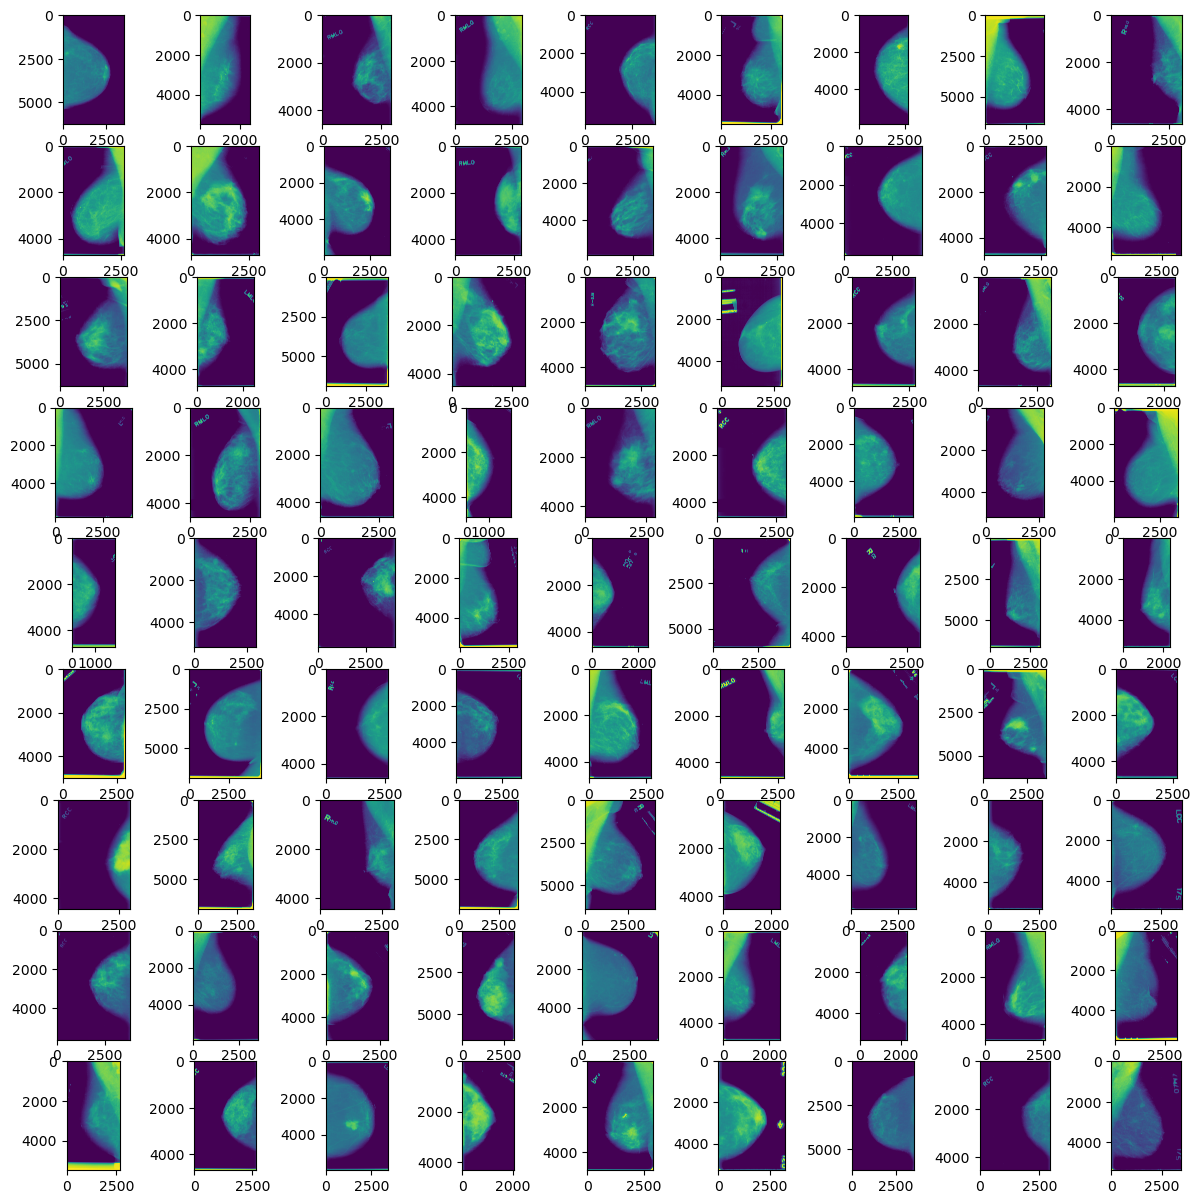

In [11]:
show_grid_of_images(full_training_images_path, 9, 9)

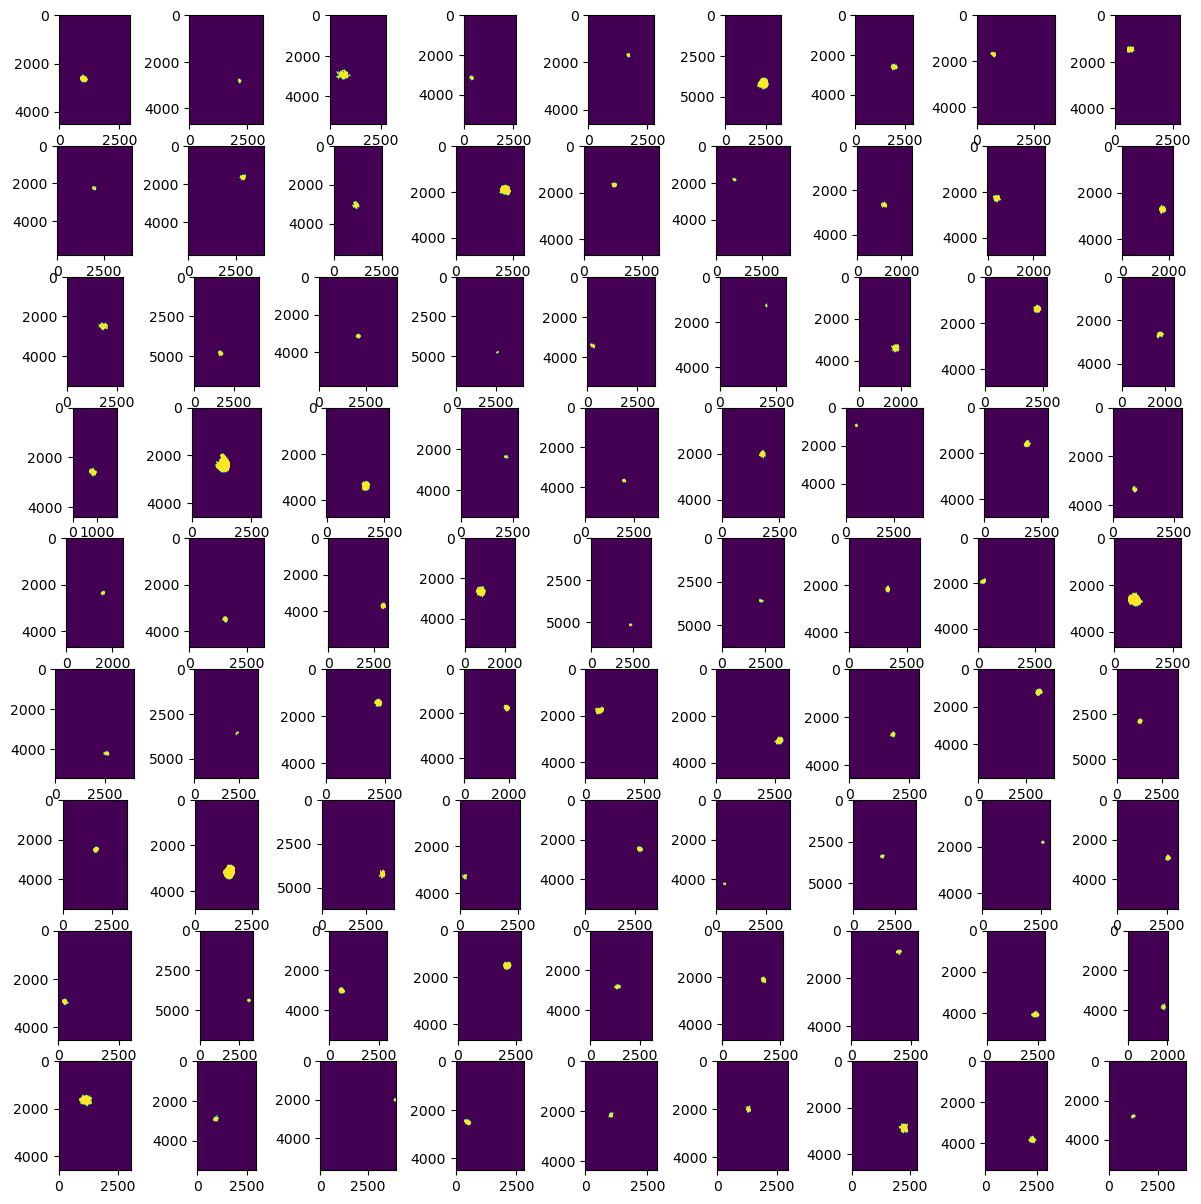

In [12]:
show_grid_of_images(ROI_test_images_path,9,9)

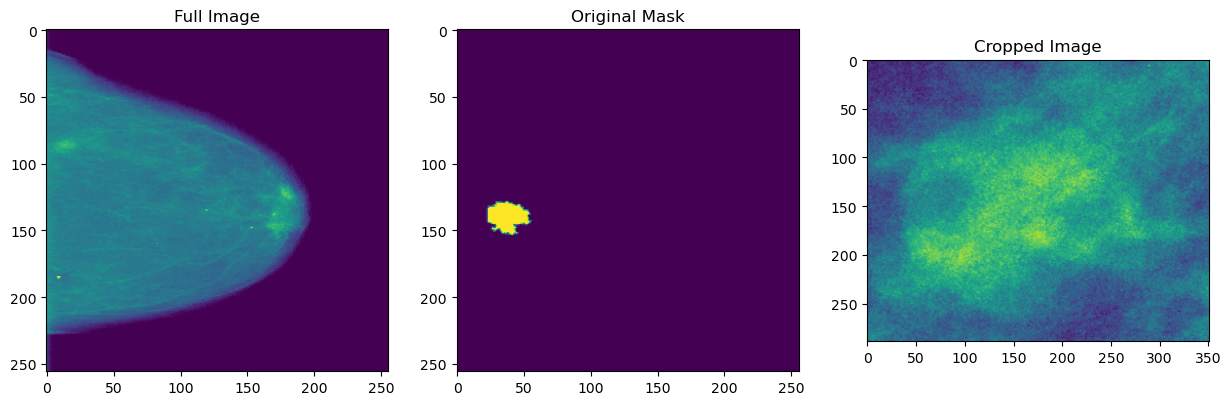

In [71]:
img_ROI = cv.imread(ROI_train_images_path.values[0], cv.IMREAD_GRAYSCALE)
img_cropped = cv.imread(cropped_train_images_path.values[0], cv.IMREAD_GRAYSCALE)
img_Full = cv.imread(full_training_images_path.values[0], cv.IMREAD_GRAYSCALE)
def show_images(img1, img2, img3,title = None ):
    fig, ax = plt.subplots(1, 3, figsize=(15, 15))
    ax[0].imshow(img1.astype('uint8'))
    ax[0].set_title('Full Image')
    ax[1].imshow(img2.astype('uint8'))
    ax[1].set_title('Original Mask')
    ax[2].imshow(img3.astype('uint8'))
    ax[2].set_title('Cropped Image')
    if title:
        title = f"Predicted mask \n IOU: {round(title,4)}"
        ax[2].set_title(title)
    plt.show()
show_images(img_Full, img_ROI, img_cropped)

## Preprocessing

### Pipeline for resizing and cleaning the images

In [14]:
resize_images(ROI_test_images_path,(256,256))
resize_images(ROI_train_images_path,(256,256))

In [15]:
resize_full_image(full_test_images_path)
resize_full_image(full_training_images_path)

### Adding ROI for similar mammography studies

In [16]:

for i in range(2, 10):
    sub_df = mass_ROI_train[mass_ROI_train['PatientID'].apply(lambda x: x.endswith(str(i)))]
    for _,row in sub_df.iterrows():
        #path to image we want to concatenate with _1
        row_img_path = row['image_path'].replace('CBIS-DDSM/jpeg', image_dir)
        img1 = cv.imread(row_img_path, cv.IMREAD_GRAYSCALE)
        #patient_id we want to delete later
        patient_id = row['PatientID']
        #patient id of top image
        patient_id_top =  row['PatientID'][0:-2] + '_1'
        img_path_2 = mass_ROI_train[mass_ROI_train['PatientID'].apply(lambda x : x == patient_id_top)].image_path.apply(lambda x: x.replace('CBIS-DDSM/jpeg', image_dir))
        if len(img_path_2.values) == 0:
            if i == 2: 
                continue
            else:
                patient_id_top =  row['PatientID'][0:-2] + '_2'
                img_path_2 = mass_ROI_train[mass_ROI_train['PatientID'].apply(lambda x : x == patient_id_top)].image_path.apply(lambda x: x.replace('CBIS-DDSM/jpeg', image_dir))
                if len(img_path_2.values) == 0:
                    continue
        img_path_2 = img_path_2.values[0]
        img2 = cv.imread(img_path_2, cv.IMREAD_GRAYSCALE)
        img3 = np.add(img1, img2)
        cv.imwrite(img_path_2, img3)
        mass_ROI_train = mass_ROI_train[mass_ROI_train.PatientID != row['PatientID']]

In [17]:

for i in range(2, 10):
    sub_df = mass_ROI_test[mass_ROI_test['PatientID'].apply(lambda x: x.endswith(str(i)))]
    for _,row in sub_df.iterrows():
        #path to image we want to concatenate with _1
        row_img_path = row['image_path'].replace('CBIS-DDSM/jpeg', image_dir)
        img1 = cv.imread(row_img_path, cv.IMREAD_GRAYSCALE)
        #patient_id we want to delete later
        patient_id = row['PatientID']
        #patient id of top image
        patient_id_top =  row['PatientID'][0:-2] + '_1'
        img_path_2 = mass_ROI_test[mass_ROI_test['PatientID'].apply(lambda x : x == patient_id_top)].image_path.apply(lambda x: x.replace('CBIS-DDSM/jpeg', image_dir))
        if len(img_path_2.values) == 0:
            if i == 2: 
                continue
            else:
                patient_id_top =  row['PatientID'][0:-2] + '_2'
                img_path_2 = mass_ROI_test[mass_ROI_test['PatientID'].apply(lambda x : x == patient_id_top)].image_path.apply(lambda x: x.replace('CBIS-DDSM/jpeg', image_dir))
                if len(img_path_2.values) == 0:
                    continue
        img_path_2 = img_path_2.values[0]
        img2 = cv.imread(img_path_2, cv.IMREAD_GRAYSCALE)
        img3 = np.add(img1, img2)
        cv.imwrite(img_path_2, img3)
        mass_ROI_test = mass_ROI_test[mass_ROI_test.PatientID != row['PatientID']]

In [18]:
mass_ROI_train.PatientID = mass_ROI_train.PatientID.apply(lambda x: x[0:-2])
mass_ROI_test.PatientID = mass_ROI_test.PatientID.apply(lambda x: x[0:-2])

In [19]:
mass_full_train = mass_full_train.sort_values(by=['PatientID'])
mass_full_test = mass_full_test.sort_values(by=['PatientID'])
mass_ROI_train = mass_ROI_train.sort_values(by=['PatientID'])
mass_ROI_test = mass_ROI_test.sort_values(by=['PatientID'])

In [20]:
cropped_train_images_path = mass_cropped_train.image_path.apply(lambda x: x.replace('CBIS-DDSM/jpeg', image_dir))
cropped_test_images_path = mass_cropped_test.image_path.apply(lambda x: x.replace('CBIS-DDSM/jpeg', image_dir))
ROI_train_images_path = mass_ROI_train.image_path.apply(lambda x: x.replace('CBIS-DDSM/jpeg', image_dir))
ROI_test_images_path = mass_ROI_test.image_path.apply(lambda x: x.replace('CBIS-DDSM/jpeg', image_dir))
full_train_images_path = mass_full_train.image_path.apply(lambda x: x.replace('CBIS-DDSM/jpeg', image_dir)).values
full_test_images_path = mass_full_test.image_path.apply(lambda x: x.replace('CBIS-DDSM/jpeg', image_dir))

In [21]:
train_X = make_dataset(full_train_images_path)
train_Y = make_dataset(ROI_train_images_path)
test_X = make_dataset(full_test_images_path)
test_Y = make_dataset(ROI_test_images_path)

In [22]:
train_X = tf.convert_to_tensor(train_X, dtype=tf.float32)
train_Y = tf.convert_to_tensor(train_Y, dtype=tf.float32)
test_X = tf.convert_to_tensor(test_X, dtype=tf.float32)
test_Y = tf.convert_to_tensor(test_Y, dtype=tf.float32)

Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB



2022-11-01 00:25:32.779372: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-11-01 00:25:32.780014: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


## VGG16-UNET Model

In [23]:
BATCH_SIZE = 16
NUM_EPOCHS = 60

In [24]:
def compute_iou(y_true, y_pred):   
    intersection = np.logical_and(y_true, y_pred)
    union = np.logical_or(y_true, y_pred)
    IOU = np.sum(intersection) / np.sum(union)
    return IOU

In [25]:
def c_iou(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    union = K.sum(y_true_f) + K.sum(y_pred_f) - intersection
    x = (intersection + 1e-15) / (union + 1e-15)
    return x

In [26]:
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + K.epsilon()) / (K.sum(y_true_f) + K.sum(y_pred_f) + K.epsilon())

In [27]:
def jaccard_distance_loss(y_true, y_pred,smooth = 100):
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    sum_ = K.sum(K.abs(y_true) + K.abs(y_pred), axis=-1)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return (1 - jac) * smooth

In [28]:
def convolutional_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
 
    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
 
    return x

In [29]:
def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = convolutional_block(x, num_filters)
    return x

In [30]:
#input shape is (height,   width,   channels)
def build_vgg16_unet(input_shape):
    inputs = Input(input_shape)

In [31]:
vgg16 = VGG16(include_top=False, weights="imagenet", input_tensor=Input(shape=(256, 256, 3)))

In [32]:
def build_vgg16_unet(input_shape):
    """ Input """
    inputs = Input(input_shape)
 
    """ Pre-trained VGG16 Model """
    vgg16 = VGG16(include_top=False, weights="imagenet", input_tensor=inputs)
 
    """ Encoder """
    s1 = vgg16.get_layer("block1_conv2").output         
    s2 = vgg16.get_layer("block2_conv2").output         
    s3 = vgg16.get_layer("block3_conv3").output         
    s4 = vgg16.get_layer("block4_conv3").output         
 
    """ Bridge """
    b1 = vgg16.get_layer("block5_conv3").output         
 
    """ Decoder """
    d1 = decoder_block(b1, s4, 256)                    
    d2 = decoder_block(d1, s3, 256)                     
    d3 = decoder_block(d2, s2, 128)                     
    d4 = decoder_block(d3, s1, 64)                      
 
    """ Output """
    outputs = Conv2D(3, 3, padding="same", activation="sigmoid")(d4)
 
    model = Model(inputs, outputs, name="VGG16_U-Net")
    return model
 
if __name__ == "__main__":
    input_shape = (256, 256, 3)
    model = build_vgg16_unet(input_shape)
    model.summary()

Model: "VGG16_U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 256, 256, 64  1792        ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv2 (Conv2D)          (None, 256, 256, 64  36928       ['block1_conv1[0][0]']           
                                )                                                       

In [33]:
steps_per_epoch = len(train_X) // BATCH_SIZE
validation_steps = len(test_X) // BATCH_SIZE
train = (train_X, train_Y)
validation_data = (test_X, test_Y)
opt = Adam(learning_rate=0.0001)
model.compile(optimizer=opt, loss=jaccard_distance_loss ,metrics = 'accuracy')
checkpoint = ModelCheckpoint("vgg16_1.h5",
                             monitor='val_acc',
                             verbose=1,
                             save_best_only=True,
                             save_weights_only=False,
                             mode='auto',
                             period=1,
                             save_freq = steps_per_epoch * 20)

early = EarlyStopping(monitor='val_acc', min_delta=0, patience=20, verbose=1, mode='auto')

history = model.fit(
    x = train_X,
    y = train_Y,
    validation_data = validation_data,
    epochs=NUM_EPOCHS,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    verbose=1,
    callbacks = [checkpoint, early]
)

Epoch 1/60


2022-11-01 00:25:36.821647: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-11-01 00:25:37.719081: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


76/76 [==============================] - ETA: 0s - loss: -1.7333 - accuracy: 0.0619

2022-11-01 00:34:32.239274: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


76/76 [==============================] - 566s 7s/step - loss: -1.7333 - accuracy: 0.0619 - val_loss: -2.2915 - val_accuracy: 0.5304
Epoch 2/60
76/76 [==============================] - 569s 7s/step - loss: -2.7218 - accuracy: 0.0440 - val_loss: -2.4162 - val_accuracy: 0.0631
Epoch 3/60
76/76 [==============================] - 582s 8s/step - loss: -3.0793 - accuracy: 0.2648 - val_loss: -2.8905 - val_accuracy: 0.0758
Epoch 4/60
76/76 [==============================] - 605s 8s/step - loss: -3.3819 - accuracy: 0.4884 - val_loss: -3.1100 - val_accuracy: 0.0259
Epoch 5/60
76/76 [==============================] - 594s 8s/step - loss: -3.5231 - accuracy: 0.2049 - val_loss: -3.1006 - val_accuracy: 0.0284
Epoch 6/60
76/76 [==============================] - 599s 8s/step - loss: -3.5027 - accuracy: 0.0489 - val_loss: -3.1251 - val_accuracy: 0.0225
Epoch 7/60
76/76 [==============================] - 595s 8s/step - loss: -3.5354 - accuracy: 0.0469 - val_loss: -3.0792 - val_accuracy: 0.0260
Epoch 8/60

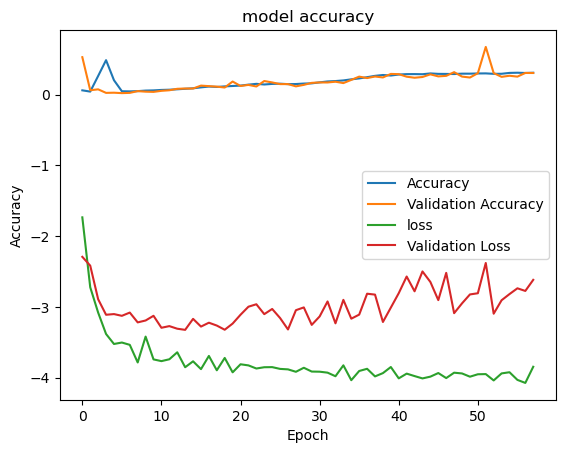

In [73]:
import matplotlib.pyplot as plt
plt.plot(history.history["accuracy"])
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Accuracy","Validation Accuracy","loss","Validation Loss"])
plt.show()

Text(0, 0.5, 'Frequency')

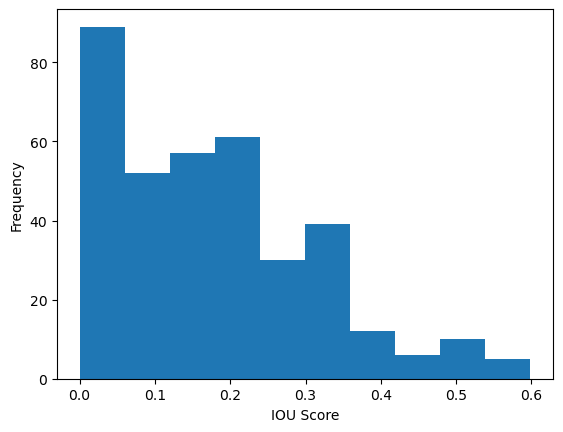

In [70]:
plt.hist(scores,bins=10);
plt.xlabel("IOU Score")
plt.ylabel("Frequency")

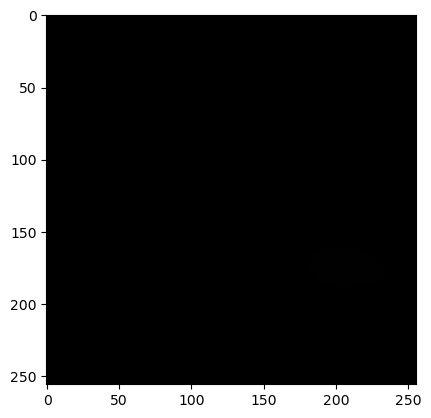

In [85]:
image = cv.imread("test_segmentation/0.jpg")
#show image
plt.imshow(image, cmap='gray')

12/12 [==============================] - 31s 3s/step


/var/folders/2_/ymn_pzpd15q321gb5xpm57700000gn/T/ipykernel_65871/97617709.py:23: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  frame_normed = np.array(frame_normed, np.int)


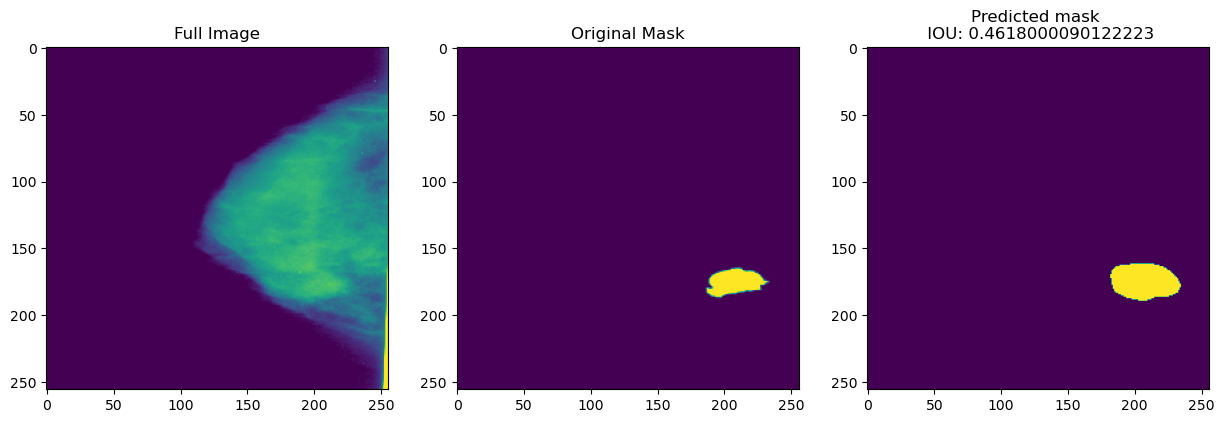

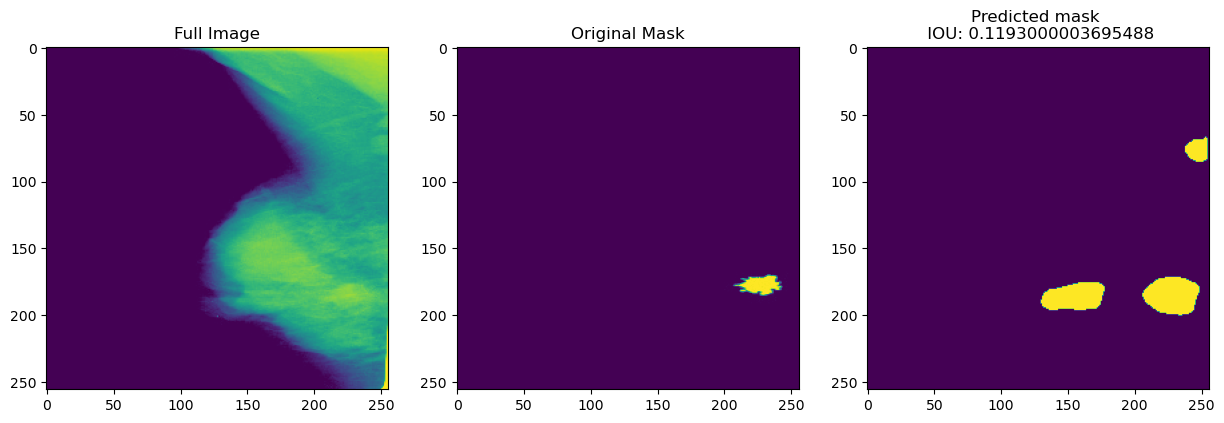

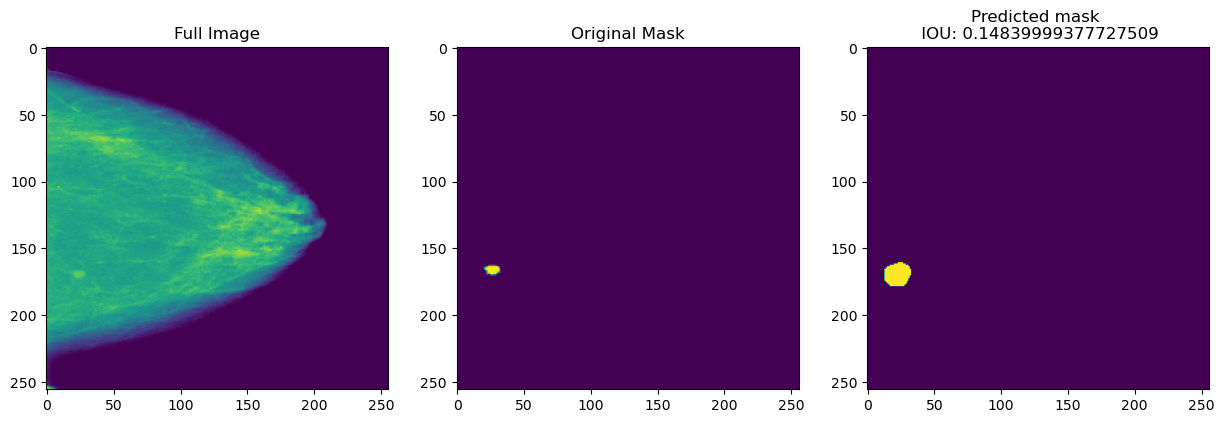

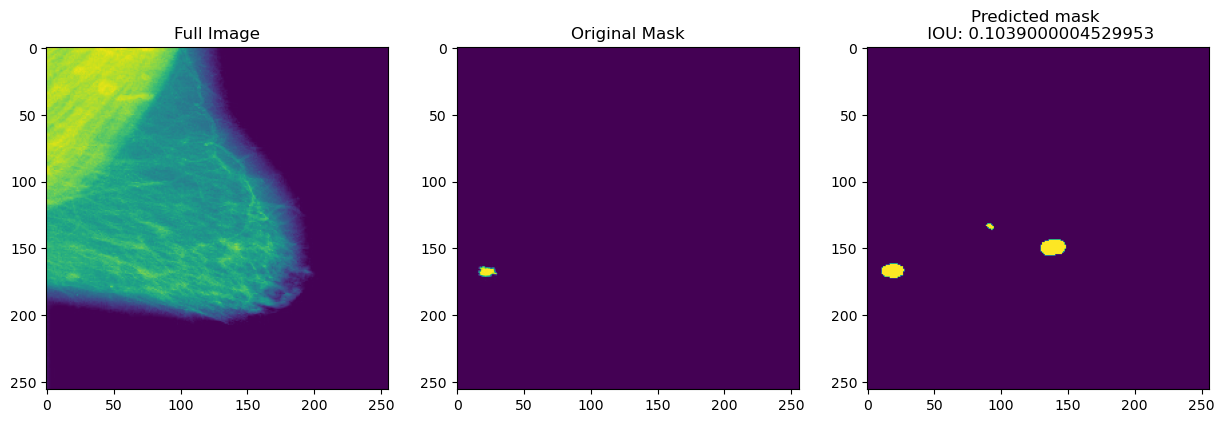

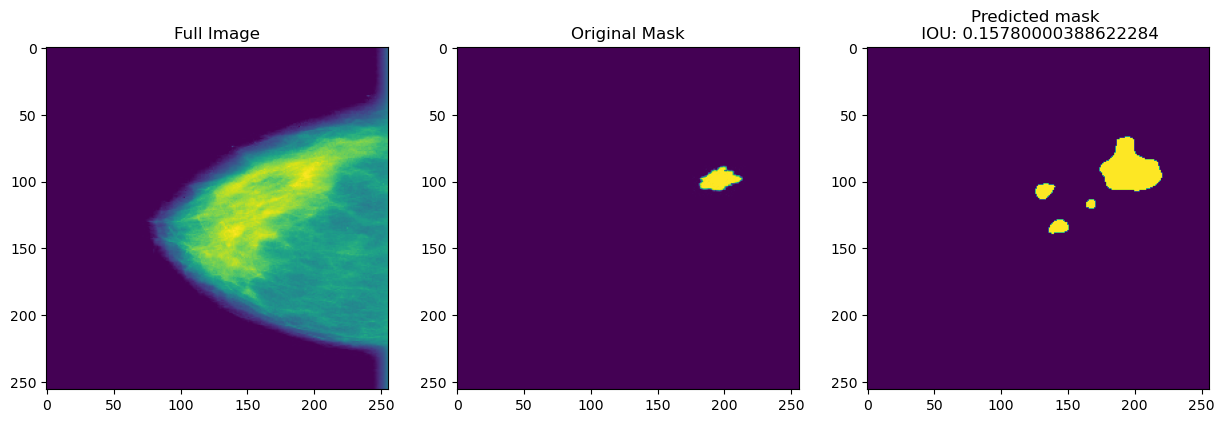

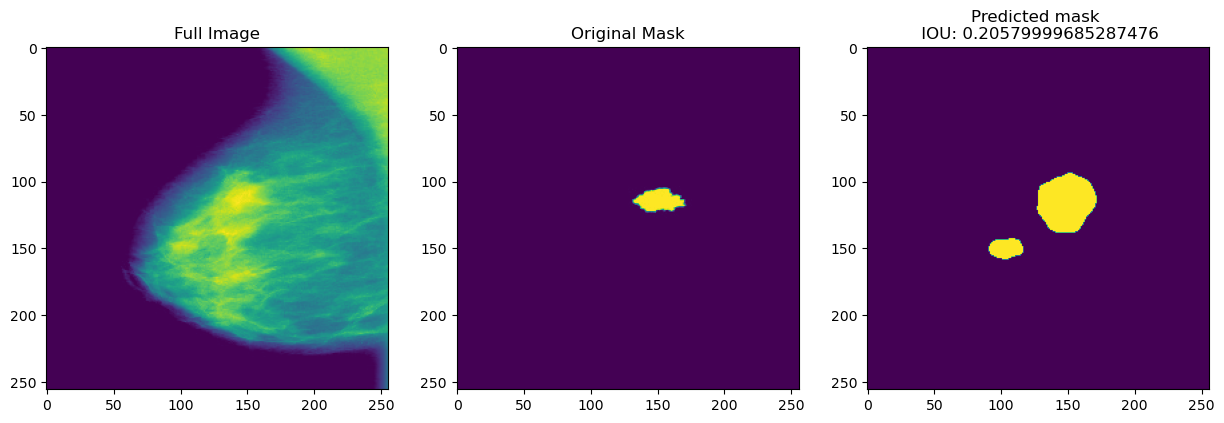

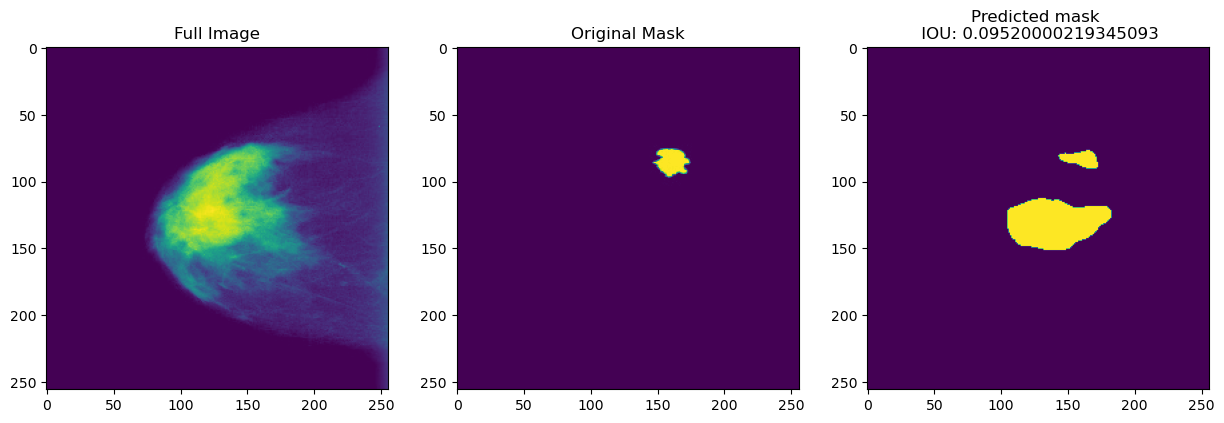

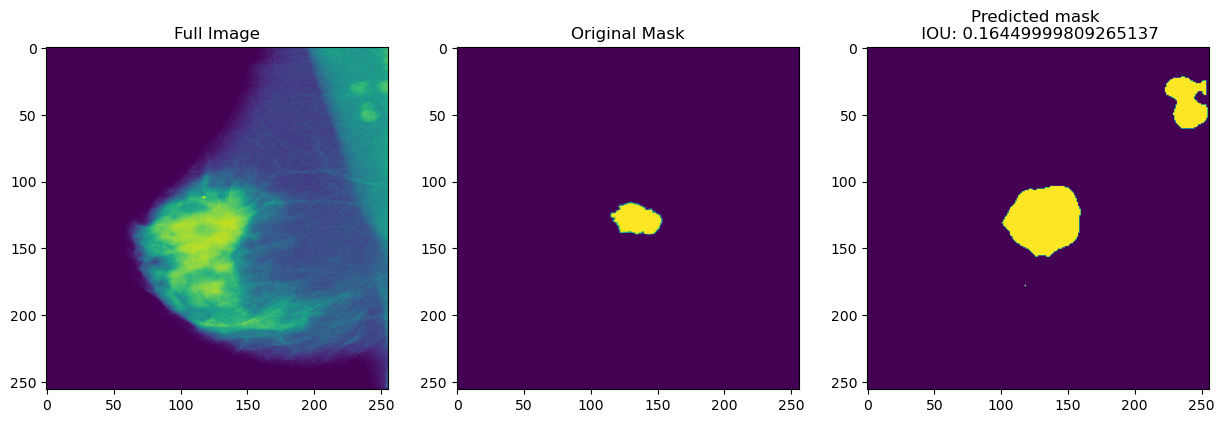

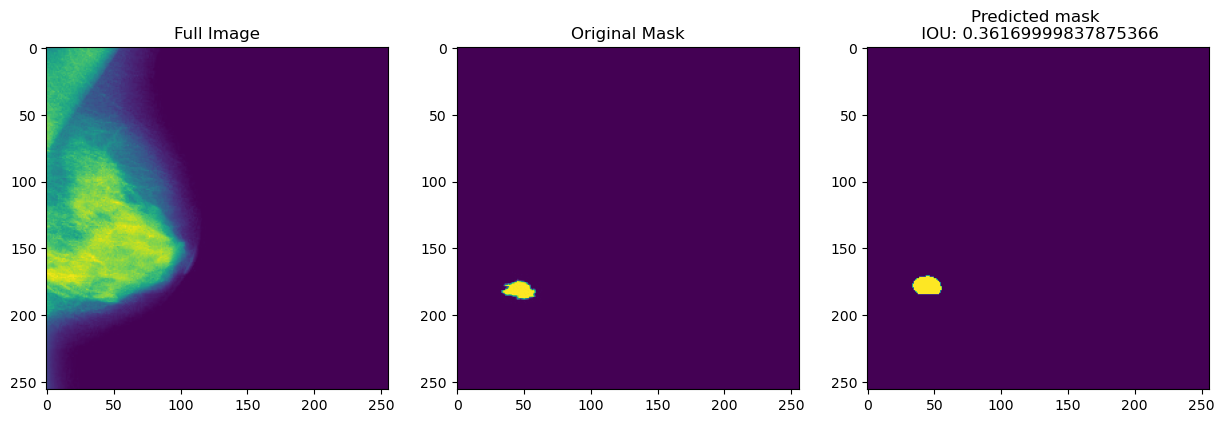

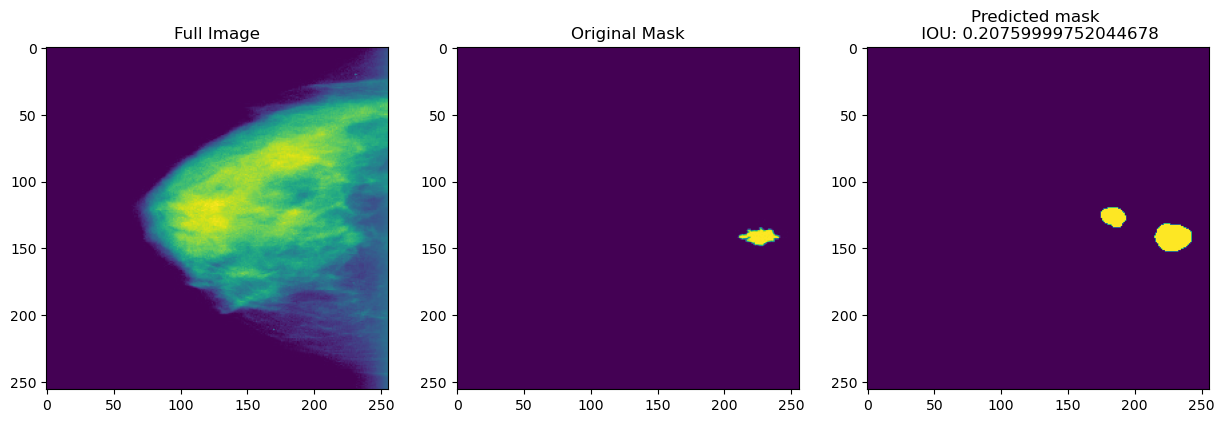

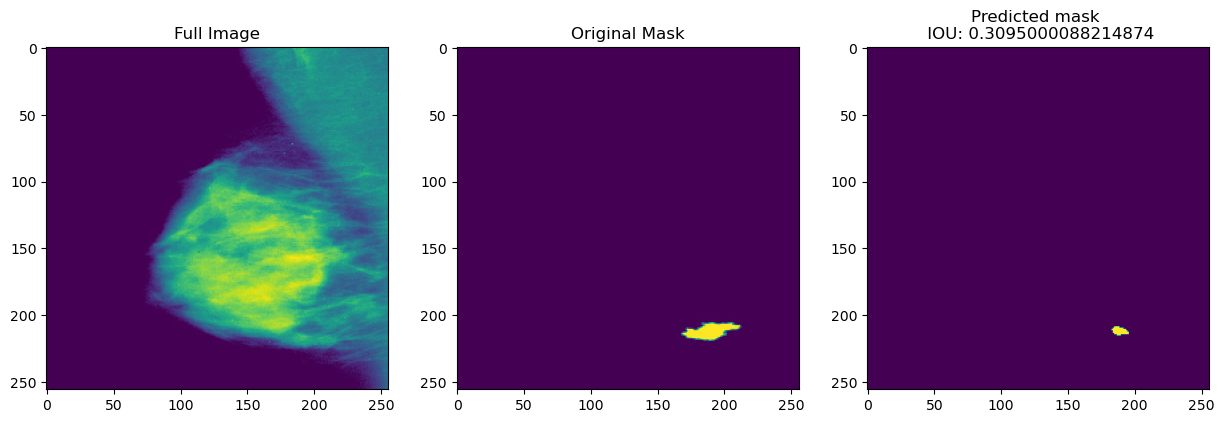

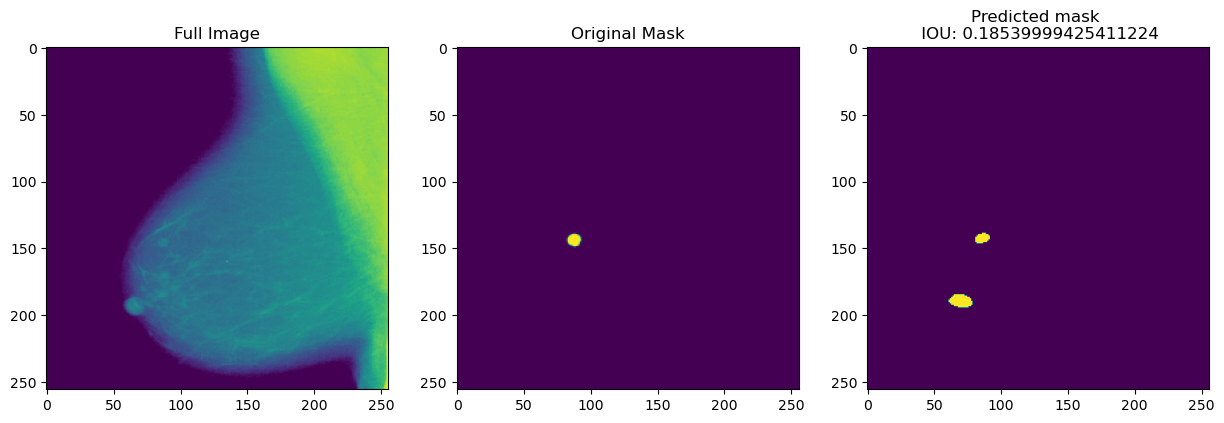

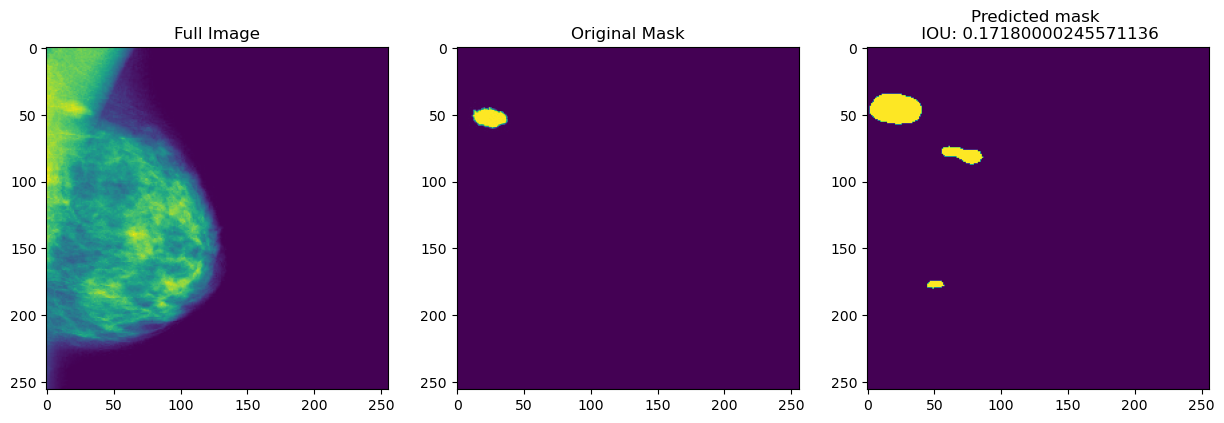

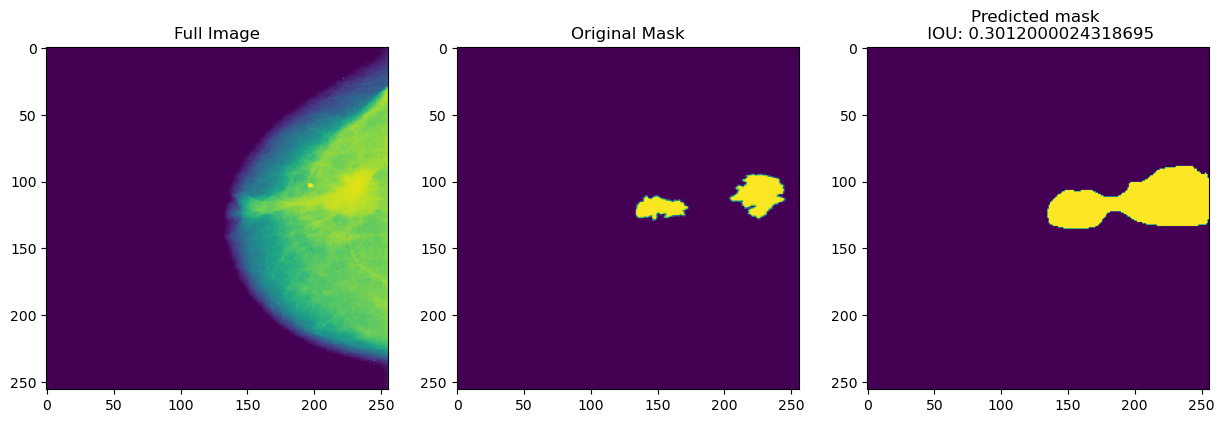

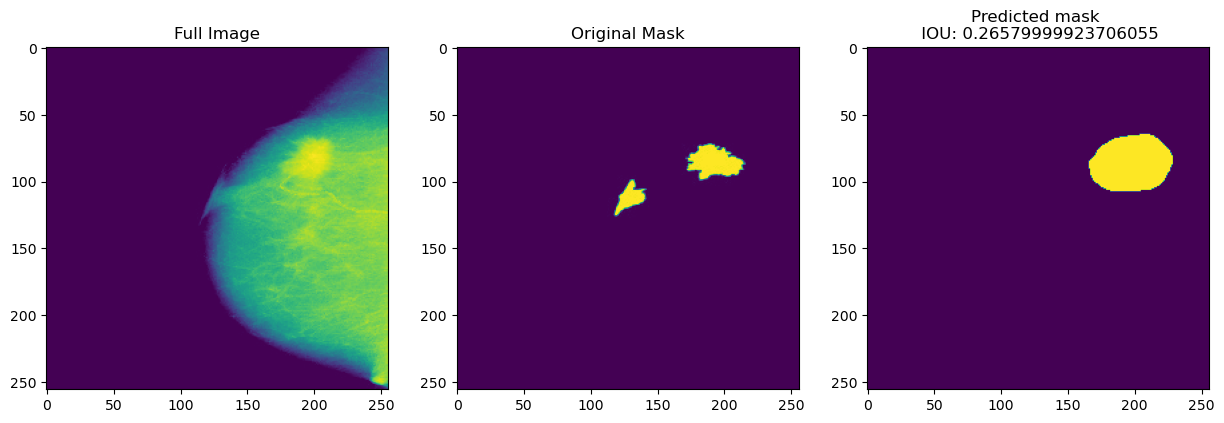

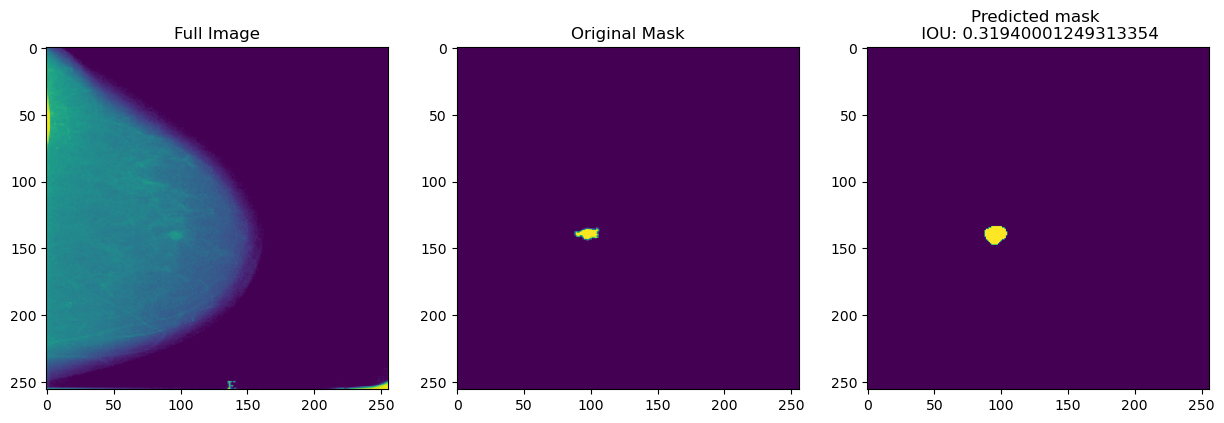

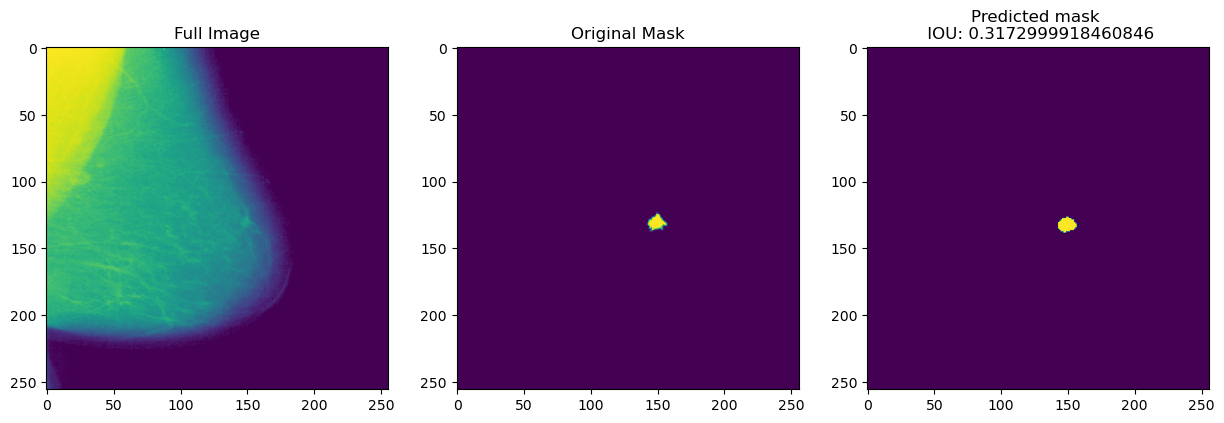

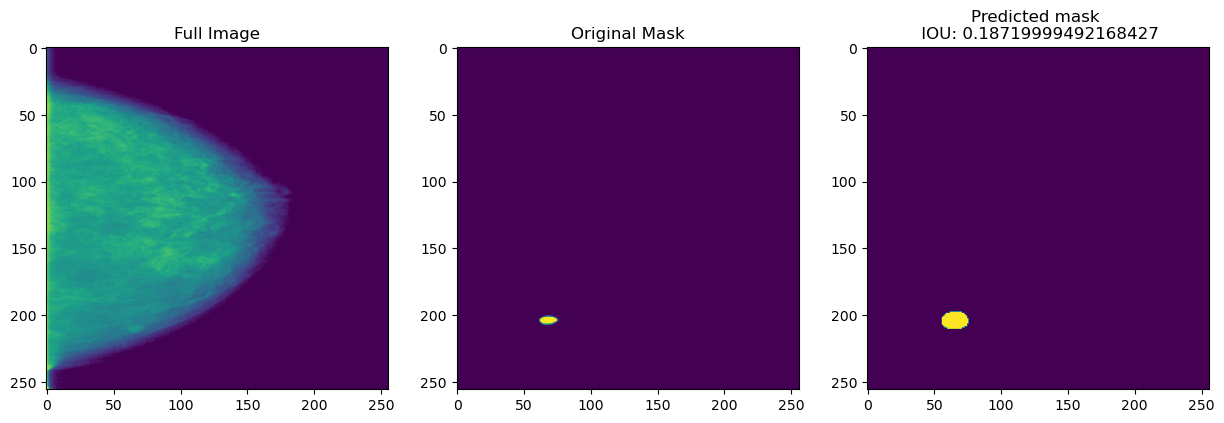

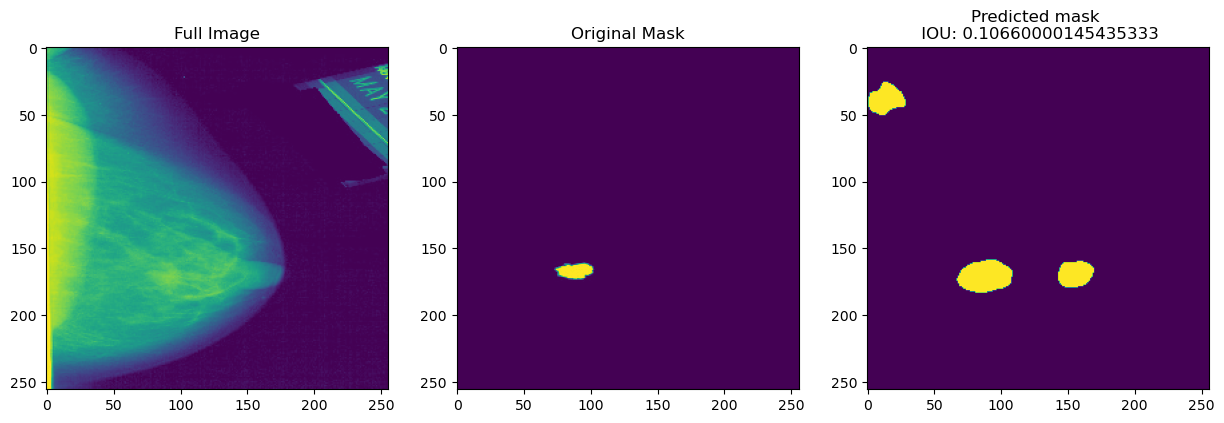

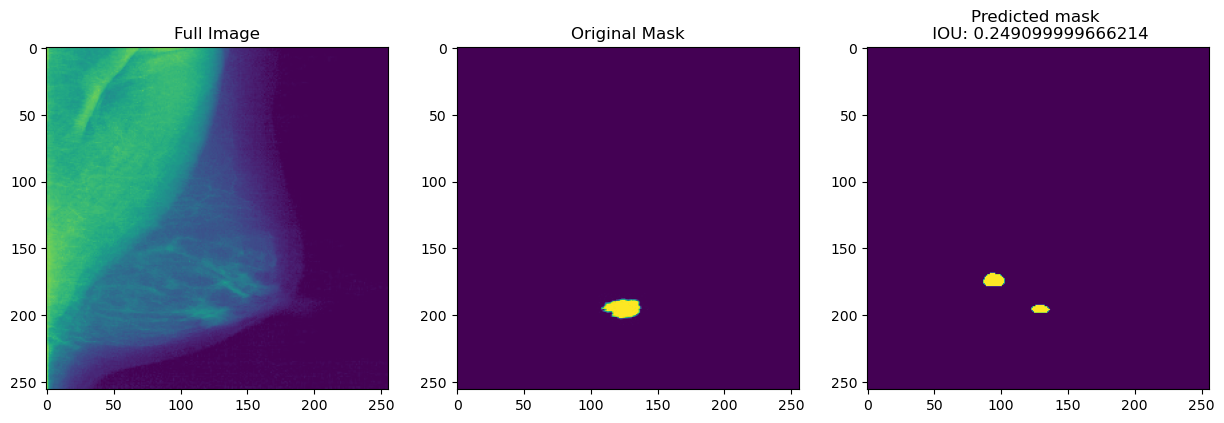

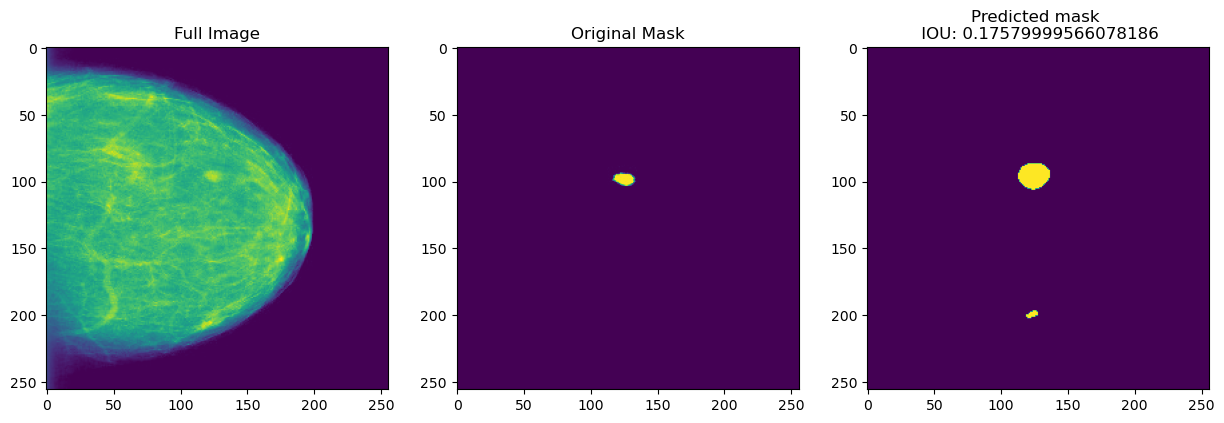

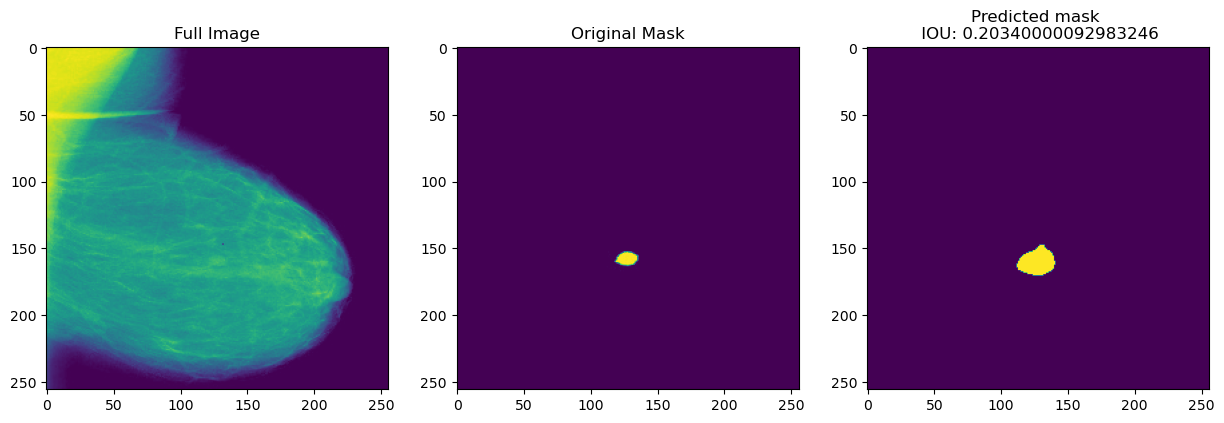

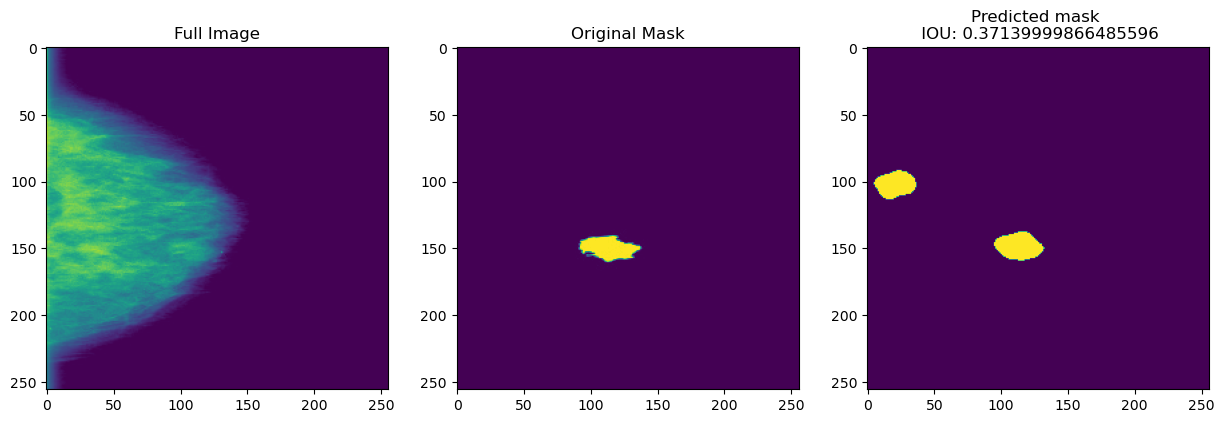

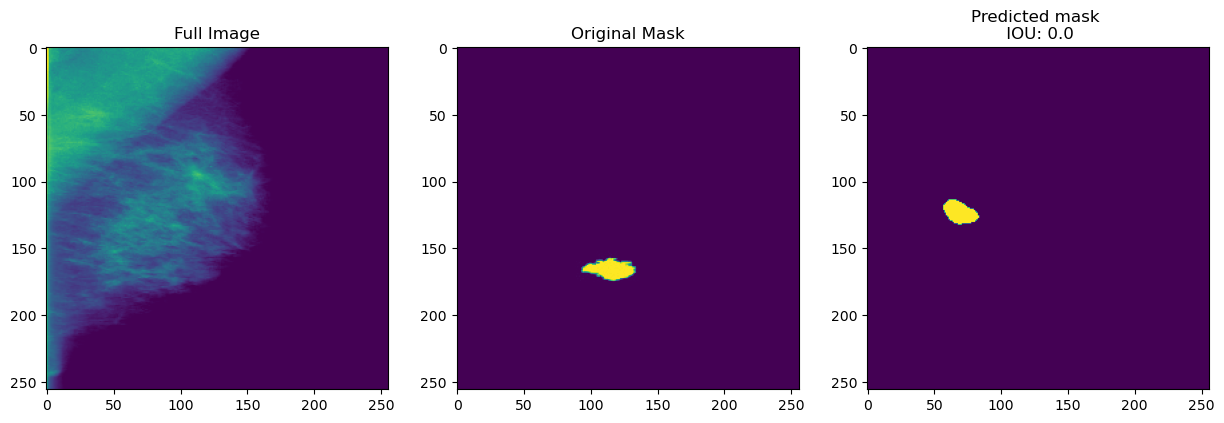

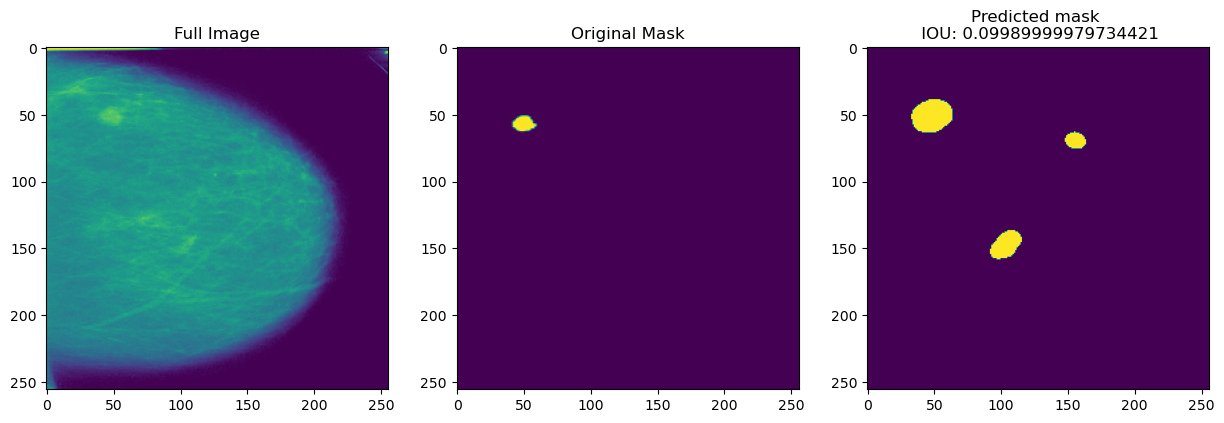

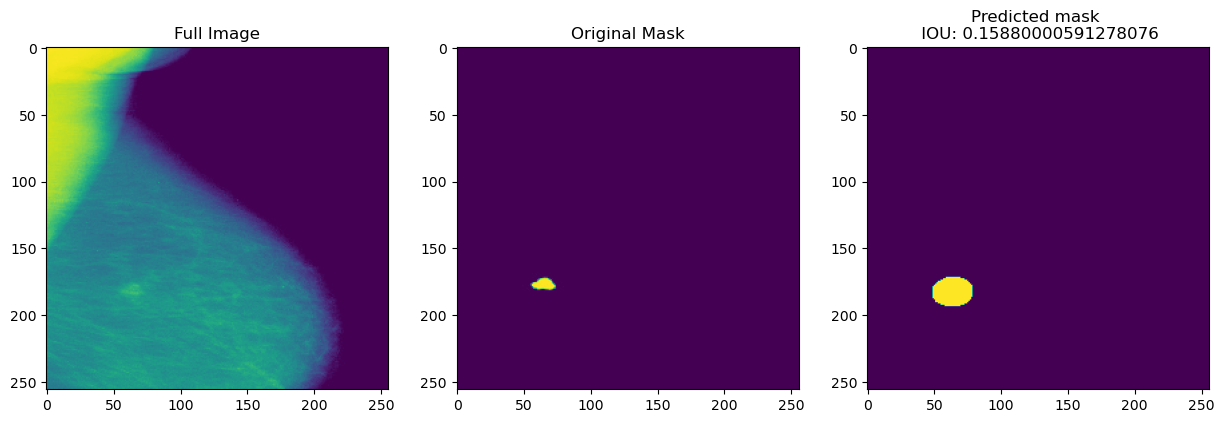

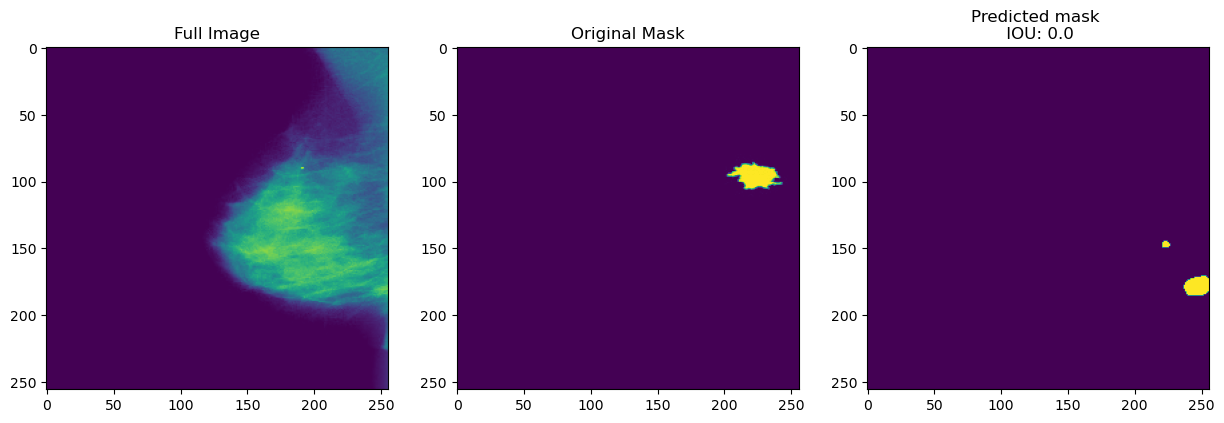

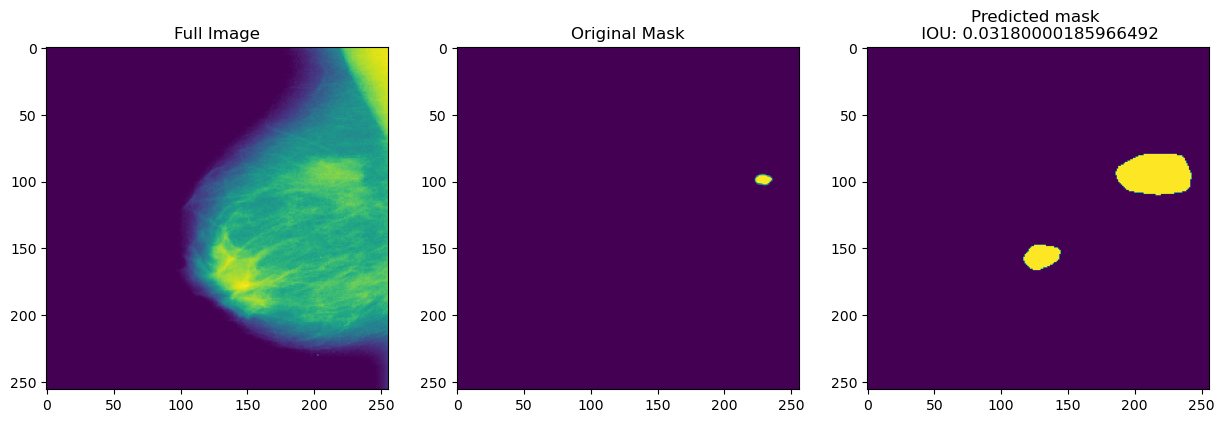

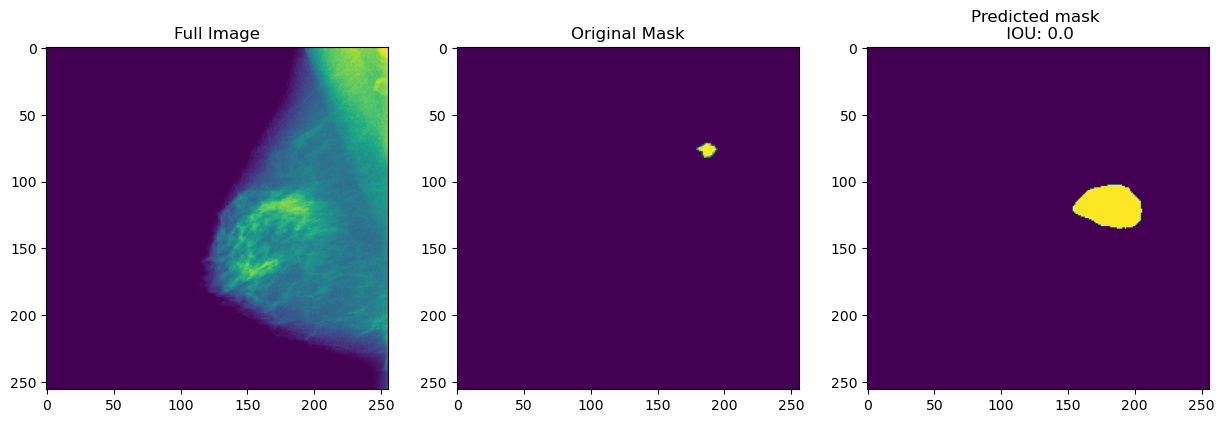

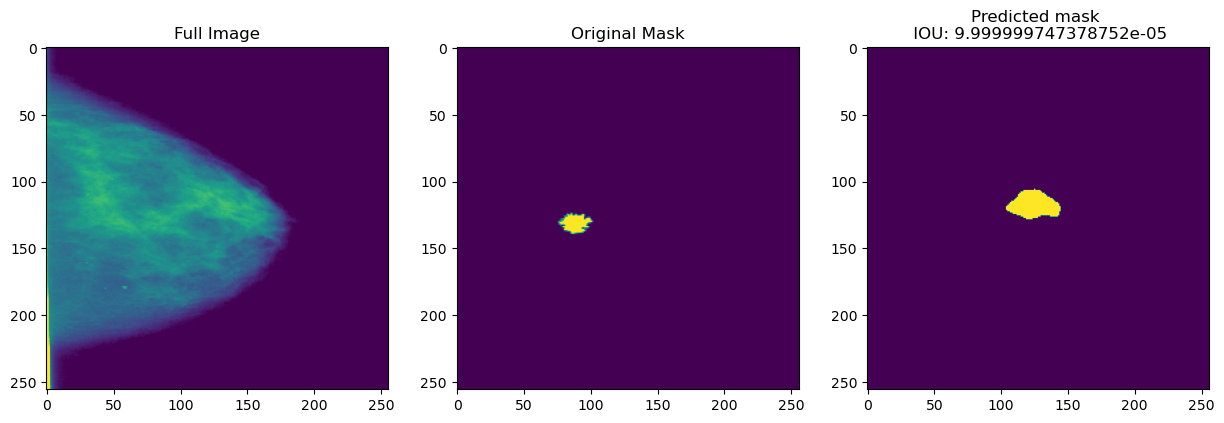

In [89]:
path = "test_segmentation"
mass_ROI_test.to_csv(os.path.join(path, "mass_ROI_test.csv"), index=False)
def create_mask(pred_mask,n = None):
        img = np.array(pred_mask)
        return img

def show_predictions(dataset=None, num=1):
        ious = []
        pred_masks = model.predict(x = test_X)
        for i in range(len(test_X)):
                image = test_X[i]
                image = np.array(image)
                image = image[:,:,0]
                mask_original = test_Y[i]
                pred_mask = create_mask(pred_masks[i],i)
                mask_original = np.array(mask_original)
                pred_norm = cv.normalize(pred_mask, None, alpha=0, beta=1, norm_type=cv.NORM_MINMAX, dtype=cv.CV_32F)
                mask_norm = cv.normalize(mask_original, None, alpha=0, beta=1, norm_type=cv.NORM_MINMAX, dtype=cv.CV_32F)
                iou = c_iou(mask_norm, pred_norm)
                mask_original = mask_original[:,:,0]
                pred_mask = pred_mask[:,:,0]
                frame_normed = 255 * (pred_mask - pred_mask.min()) / (pred_mask.max() - pred_mask.min())
                frame_normed = np.array(frame_normed, np.int)
                cv.imwrite(os.path.join(path , f'{i}.jpg'), frame_normed)
                ious.append(iou)
                if(i < 30):
                        show_images(image, mask_original, create_mask(pred_mask),iou.numpy())
        return ious 
scores = show_predictions()